In [1]:
import numpy as np
import pandas as pd   # ← typo here: should be 'import'
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
df = pd.read_csv("../../data/benin-malanville.csv")
df.describe()

,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
count,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,0.0
mean,240.559452,167.187516,115.358961,236.589496,228.883576,28.179683,54.487969,2.121113,2.809195,0.473390,153.435172,8.582407,994.197199,0.000923,0.001905,35.246026,32.471736,NaN
std,331.131327,261.710501,158.691074,326.894859,316.536515,5.924297,28.073069,1.603466,2.029120,0.273395,102.332842,6.385864,2.474993,0.030363,0.037115,14.807258,12.348743,NaN
min,-12.900000,-7.800000,-12.600000,0.000000,0.000000,11.000000,2.100000,0.000000,0.000000,0.000000,0.000000,0.000000,985.000000,0.000000,0.000000,9.000000,8.100000,NaN
25%,-2.000000,-0.500000,-2.100000,0.000000,0.000000,24.200000,28.800000,1.000000,1.300000,0.400000,59.000000,3.700000,993.000000,0.000000,0.000000,24.200000,23.600000,NaN
50%,1.800000,-0.100000,1.600000,4.500000,4.300000,28.000000,55.100000,1.900000,2.600000,0.500000,181.000000,8.600000,994.000000,0.000000,0.000000,30.000000,28.900000,NaN
75%,483.400000,314.200000,216.300000,463.700000,447.900000,32.300000,80.100000,3.100000,4.100000,0.600000,235.100000,12.300000,996.000000,0.000000,0.000000,46.900000,41.500000,NaN
max,1413.000000,952.300000,759.200000,1342.300000,1342.300000,43.800000,100.000000,19.500000,26.600000,4.200000,360.000000,99.400000,1003.000000,1.000000,2.500000,81.000000,72.500000,NaN


In [3]:
null_percentage = df.isna().mean() * 100  
columns_with_high_nulls = null_percentage[null_percentage > 5]
print(columns_with_high_nulls)

Comments    100.0
dtype: float64


In [4]:
from scipy.stats import zscore
import os

# Step 1: Look for missing values
missing_summary = df[['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']].isna().sum()
print("Missing values:\n", missing_summary)

# Step 2: Compute Z-scores and flag outliers
cols_to_check = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
z_scores = df[cols_to_check].apply(zscore)

# Flag rows where any |Z| > 3
outlier_flags = (z_scores.abs() > 3)
df['is_outlier'] = outlier_flags.any(axis=1)

# Optionally print or inspect outliers
print("Number of outlier rows:", df['is_outlier'].sum())

# Step 3: Drop or impute missing values in key columns
# Impute with median for selected columns
for col in cols_to_check:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].median())

# Step 4: Drop outlier rows (optional, if not just flagging)
df_cleaned = df[~df['is_outlier']].drop(columns='is_outlier')

Missing values:
 GHI       0
DNI       0
DHI       0
ModA      0
ModB      0
WS        0
WSgust    0
dtype: int64
Number of outlier rows: 7740


In [5]:
country = 'benin'  # Replace with actual country
os.makedirs('data', exist_ok=True)
df_cleaned.to_csv(f'data/{country}_clean.csv', index=False)

print(f"Cleaned data exported to data/{country}_clean.csv")

Cleaned data exported to data/benin_clean.csv


In [6]:
df = pd.read_csv('data/benin_clean.csv', parse_dates=['Timestamp'])

# Ensure Timestamp is datetime and set as index
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

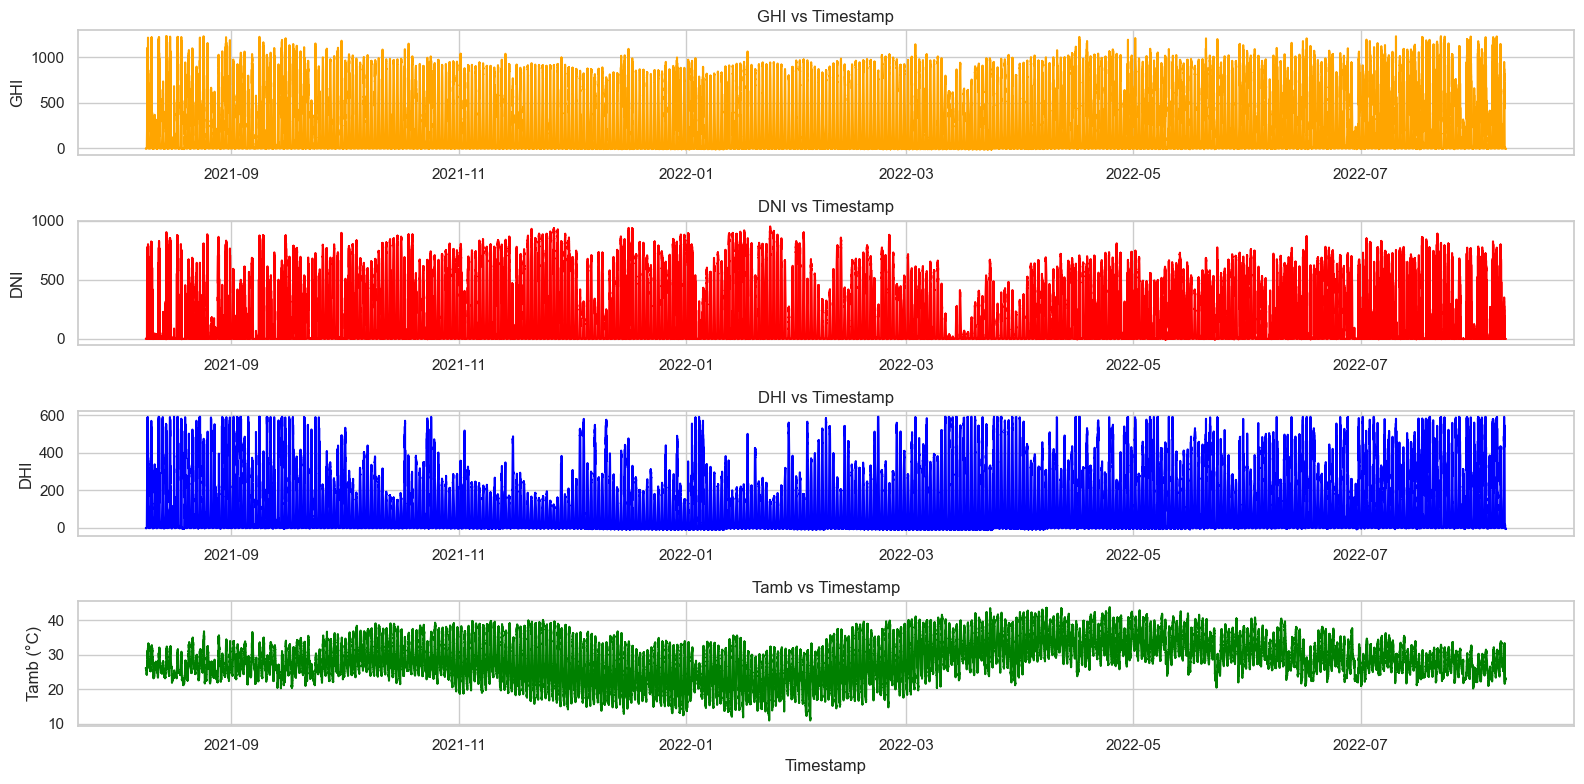

In [7]:
sns.set(style='whitegrid')

# Plot GHI, DNI, DHI, Tamb vs Timestamp
plt.figure(figsize=(16, 8))

# GHI
plt.subplot(4, 1, 1)
sns.lineplot(x='Timestamp', y='GHI', data=df, color='orange')
plt.title('GHI vs Timestamp')
plt.xlabel('')
plt.ylabel('GHI')

# DNI
plt.subplot(4, 1, 2)
sns.lineplot(x='Timestamp', y='DNI', data=df, color='red')
plt.title('DNI vs Timestamp')
plt.xlabel('')
plt.ylabel('DNI')

# DHI
plt.subplot(4, 1, 3)
sns.lineplot(x='Timestamp', y='DHI', data=df, color='blue')
plt.title('DHI vs Timestamp')
plt.xlabel('')
plt.ylabel('DHI')

# Tamb
plt.subplot(4, 1, 4)
sns.lineplot(x='Timestamp', y='Tamb', data=df, color='green')
plt.title('Tamb vs Timestamp')
plt.xlabel('Timestamp')
plt.ylabel('Tamb (°C)')

plt.tight_layout()
plt.show()

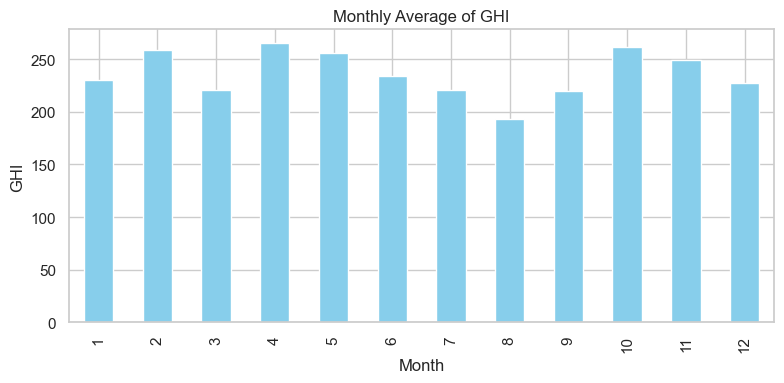

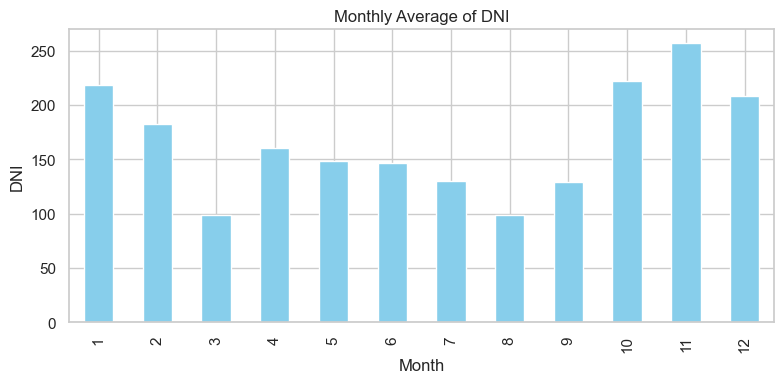

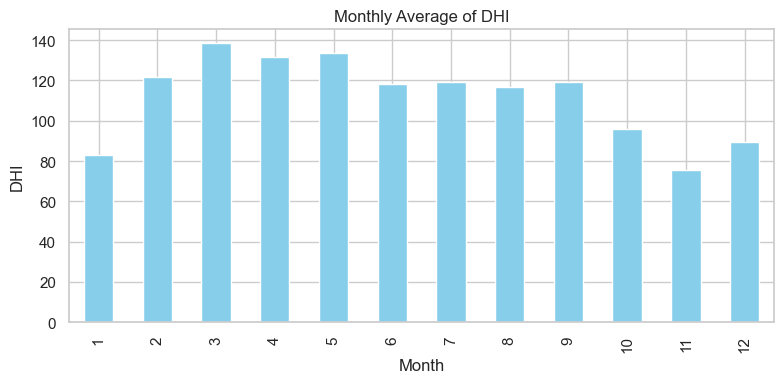

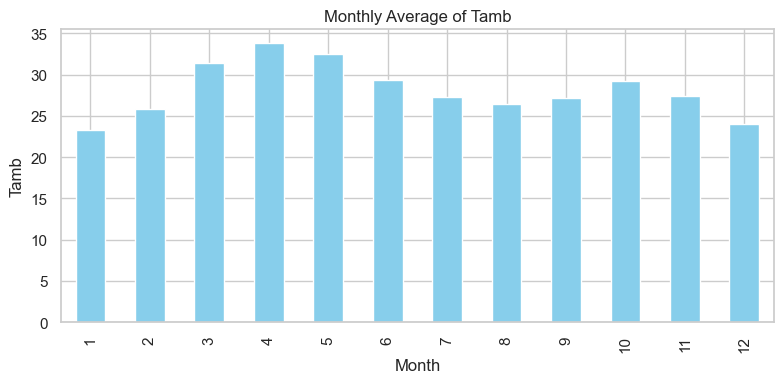

In [11]:
df['Month'] = df.index.month
monthly_avg = df.groupby('Month')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()
for col in ['GHI', 'DNI', 'DHI', 'Tamb']:
    plt.figure(figsize=(8,4))
    monthly_avg[col].plot(kind='bar', color='skyblue')
    plt.title(f'Monthly Average of {col}')
    plt.xlabel('Month')
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

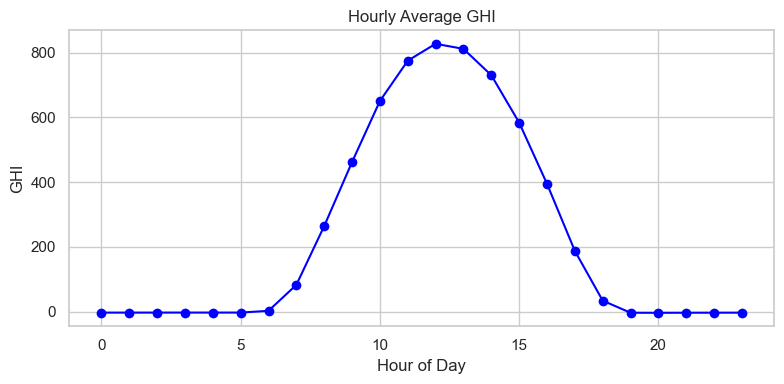

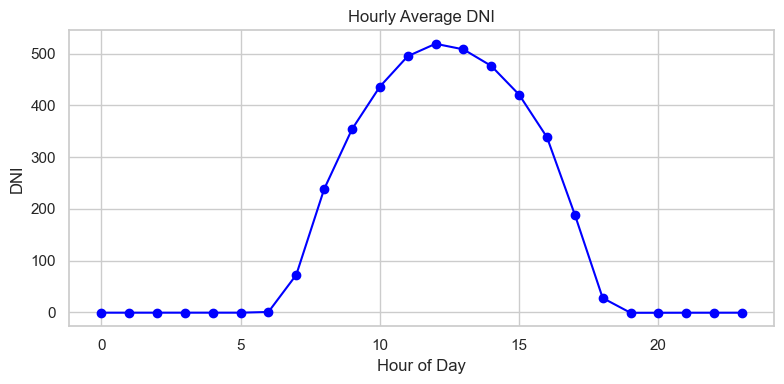

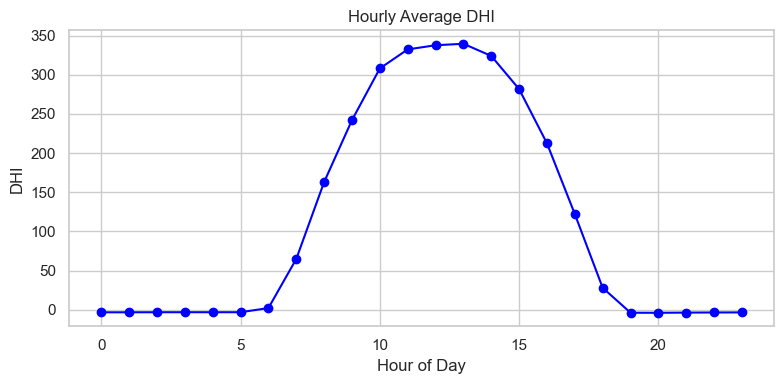

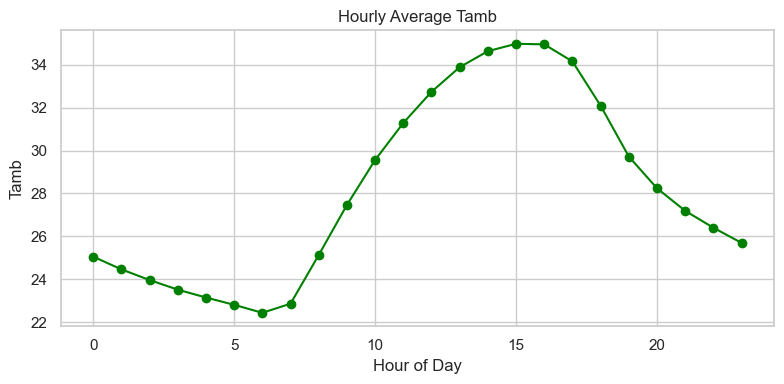

In [12]:
df['Hour'] = df.index.hour
hourly_avg = df.groupby('Hour')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

for col in ['GHI', 'DNI', 'DHI', 'Tamb']:
    plt.figure(figsize=(8,4))
    plt.plot(hourly_avg.index, hourly_avg[col], marker='o', color='green' if col=='Tamb' else 'blue')
    plt.title(f'Hourly Average {col}')
    plt.xlabel('Hour of Day')
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

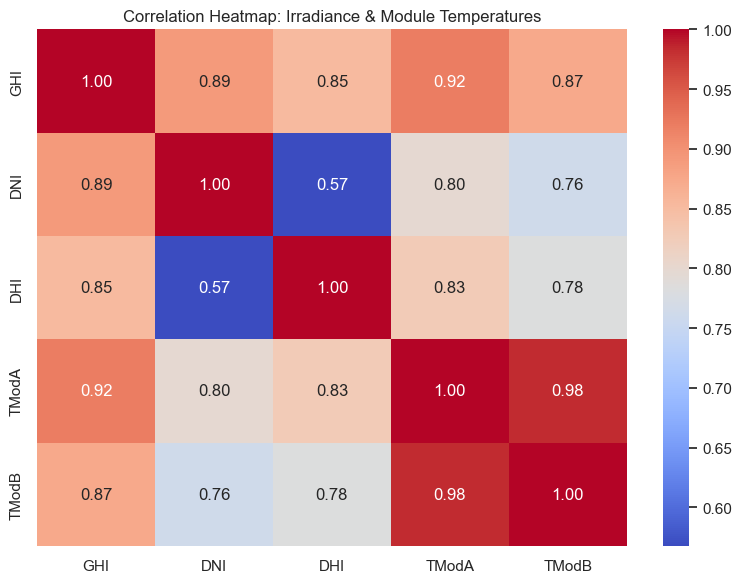

In [16]:
# Select relevant columns
corr_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
corr_matrix = df[corr_cols].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap: Irradiance & Module Temperatures')
plt.tight_layout()
plt.show()

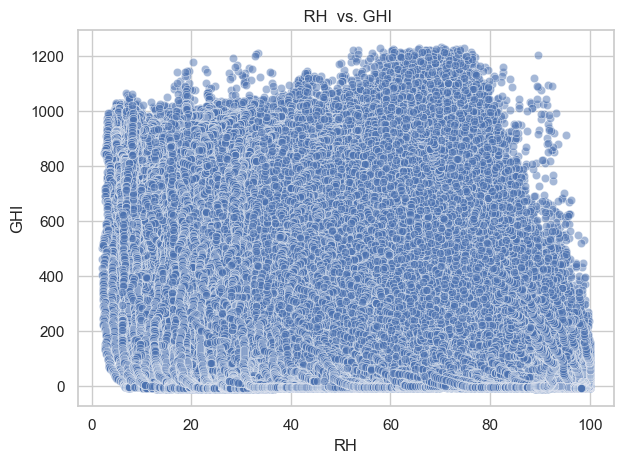

In [22]:
sns.scatterplot(data=df, x='RH', y='GHI', alpha=0.5)
plt.title(' RH  vs. GHI')  # Corrected this line
plt.xlabel('RH')
plt.ylabel('GHI')
plt.grid(True)
plt.tight_layout()
plt.show()

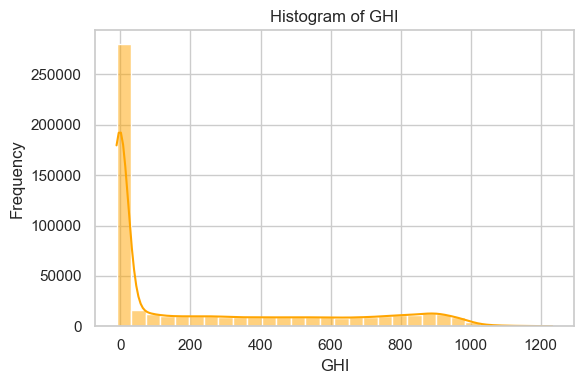

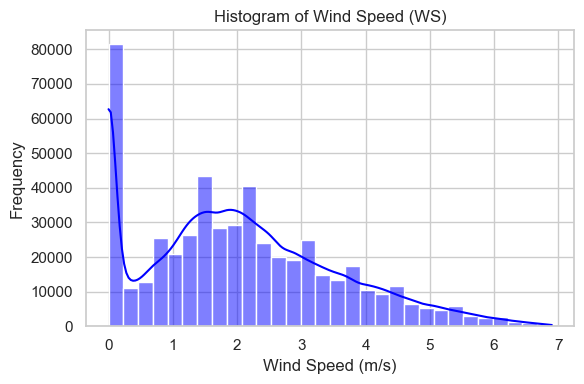

In [23]:
# Histogram for GHI
plt.figure(figsize=(6, 4))
sns.histplot(df['GHI'], bins=30, kde=True, color='orange')
plt.title('Histogram of GHI')
plt.xlabel('GHI')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# Histogram for WS
plt.figure(figsize=(6, 4))
sns.histplot(df['WS'], bins=30, kde=True, color='blue')
plt.title('Histogram of Wind Speed (WS)')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

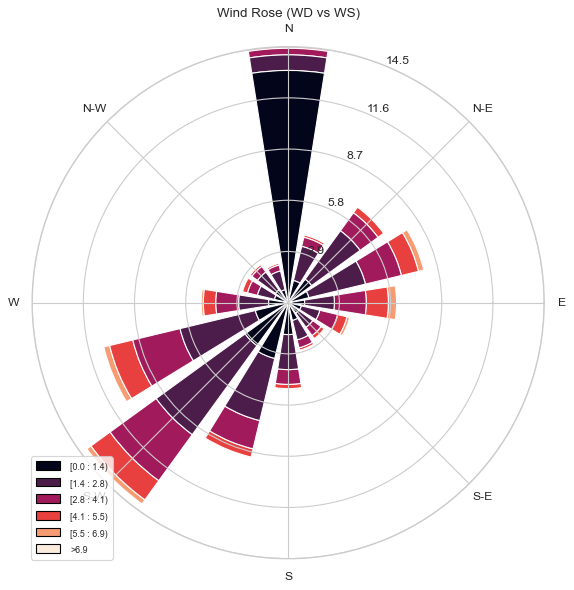

In [24]:
from windrose import WindroseAxes

# Create windrose plot
ax = WindroseAxes.from_ax()
ax.bar(df['WD'], df['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_title('Wind Rose (WD vs WS)')
ax.set_legend()
plt.show()

In [25]:
print("Correlation between RH and Tamb:", df['RH'].corr(df['Tamb']))
print("Correlation between RH and GHI:", df['RH'].corr(df['GHI']))

Correlation between RH and Tamb: -0.40950706436836365
Correlation between RH and GHI: -0.353636620042372


Expect negative correlation:

As temperature or solar radiation increases, RH often decreases (warmer air holds more moisture, reducing relative humidity).

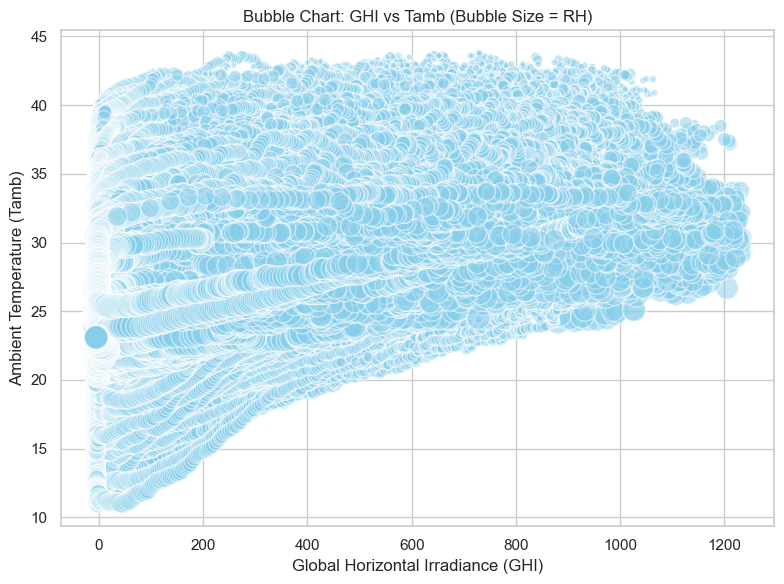

In [26]:
sizes = df['RH'] / df['RH'].max() * 300

plt.figure(figsize=(8, 6))
plt.scatter(df['GHI'], df['Tamb'], s=sizes, alpha=0.5, c='skyblue', edgecolors='w')
plt.xlabel('Global Horizontal Irradiance (GHI)')
plt.ylabel('Ambient Temperature (Tamb)')
plt.title('Bubble Chart: GHI vs Tamb (Bubble Size = RH)')
plt.grid(True)
plt.tight_layout()
plt.show()

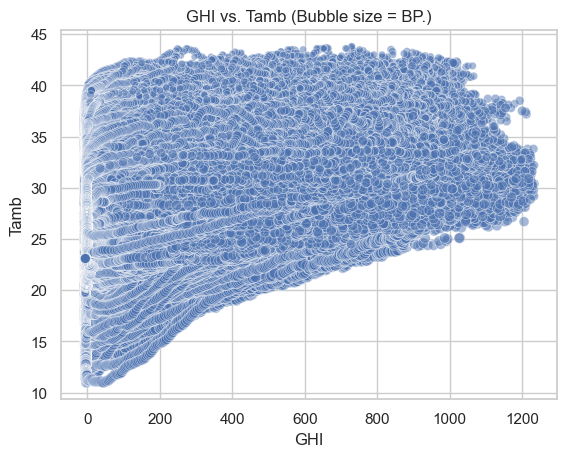

In [29]:
sns.scatterplot(data=df, x='GHI', y='Tamb', size='BP', alpha=0.5, legend=False)
plt.title('GHI vs. Tamb (Bubble size = BP.)')
plt.show()